In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from zipfile import ZipFile 
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import imutils

In [ ]:
! unzip "/content/drive/MyDrive/train.zip" -d "/content/"
! unzip "/content/drive/MyDrive/train_masks.zip" -d "/content/"

In [ ]:
print("Train set:  ", len(os.listdir("/content/train")))
print("Train masks:", len(os.listdir("/content/train_masks")))

Train set:   5088
Train masks: 5088


In [ ]:
car_ids = []
paths = []
for dirname, _, filenames in os.walk('/content/train'):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        paths.append(path)
        
        car_id = filename.split(".")[0]
        car_ids.append(car_id)

d = {"id": car_ids, "car_path": paths}
df = pd.DataFrame(data = d)
df = df.set_index('id')
df

,car_path
id,
f8b6f4c39204_04,/content/train/f8b6f4c39204_04.jpg
26ccab021981_04,/content/train/26ccab021981_04.jpg
11acc40dc0ea_13,/content/train/11acc40dc0ea_13.jpg
bf92e198d9b6_10,/content/train/bf92e198d9b6_10.jpg
0ce66b539f52_07,/content/train/0ce66b539f52_07.jpg
...,...
a2df64508b97_10,/content/train/a2df64508b97_10.jpg
ed13cbcdd5d8_08,/content/train/ed13cbcdd5d8_08.jpg
b98c63cd6102_15,/content/train/b98c63cd6102_15.jpg


In [ ]:
car_ids = []
mask_path = []
for dirname, _, filenames in os.walk('/content/train_masks'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        mask_path.append(path)
        
        car_id = filename.split(".")[0]
        car_id = car_id.split("_mask")[0]
        car_ids.append(car_id)

        
d = {"id": car_ids,"mask_path": mask_path}
mask_df = pd.DataFrame(data = d)
mask_df = mask_df.set_index('id')
mask_df

,mask_path
id,
1ba84b81628e_06,/content/train_masks/1ba84b81628e_06_mask.gif
34defeec3ce6_07,/content/train_masks/34defeec3ce6_07_mask.gif
ba7e7421003b_08,/content/train_masks/ba7e7421003b_08_mask.gif
df642435a951_04,/content/train_masks/df642435a951_04_mask.gif
562706000bd7_08,/content/train_masks/562706000bd7_08_mask.gif
...,...
08a646be6b30_05,/content/train_masks/08a646be6b30_05_mask.gif
e6892bf10d31_12,/content/train_masks/e6892bf10d31_12_mask.gif
1258cf954183_07,/content/train_masks/1258cf954183_07_mask.gif


In [ ]:
df["mask_path"] = mask_df["mask_path"]
df

,car_path,mask_path
id,,
f8b6f4c39204_04,/content/train/f8b6f4c39204_04.jpg,/content/train_masks/f8b6f4c39204_04_mask.gif
26ccab021981_04,/content/train/26ccab021981_04.jpg,/content/train_masks/26ccab021981_04_mask.gif
11acc40dc0ea_13,/content/train/11acc40dc0ea_13.jpg,/content/train_masks/11acc40dc0ea_13_mask.gif
bf92e198d9b6_10,/content/train/bf92e198d9b6_10.jpg,/content/train_masks/bf92e198d9b6_10_mask.gif
0ce66b539f52_07,/content/train/0ce66b539f52_07.jpg,/content/train_masks/0ce66b539f52_07_mask.gif
...,...,...
a2df64508b97_10,/content/train/a2df64508b97_10.jpg,/content/train_masks/a2df64508b97_10_mask.gif
ed13cbcdd5d8_08,/content/train/ed13cbcdd5d8_08.jpg,/content/train_masks/ed13cbcdd5d8_08_mask.gif
b98c63cd6102_15,/content/train/b98c63cd6102_15.jpg,/content/train_masks/b98c63cd6102_15_mask.gif


In [ ]:
img_size = [256,256]

def data_augmentation(car_img, mask_img):

    if tf.random.uniform(()) > 0.5:
        car_img = tf.image.flip_left_right(car_img)
        mask_img = tf.image.flip_left_right(mask_img)

    return car_img, mask_img

def preprocessing(car_path, mask_path):
    car_img = tf.io.read_file(car_path) 
    car_img = tf.image.decode_jpeg(car_img, channels=3)
    car_img = tf.image.resize(car_img, img_size)
    car_img = tf.cast(car_img, tf.float32) / 255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)
    
    
    return car_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["car_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["car_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

In [ ]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)

In [ ]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 16
BUFFER_SIZE = 1000

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

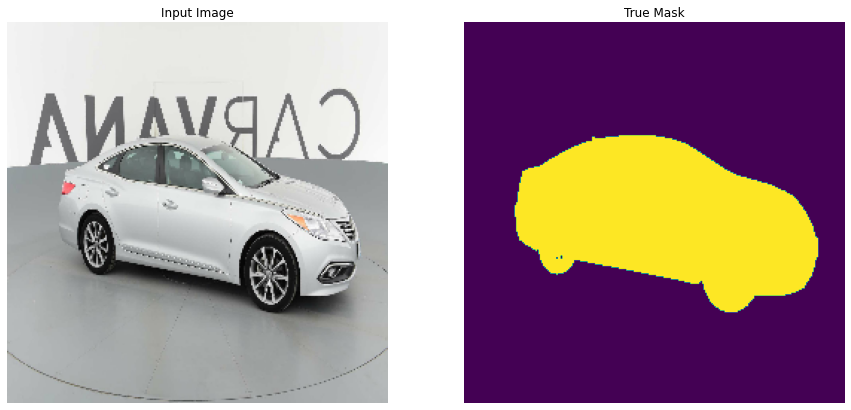

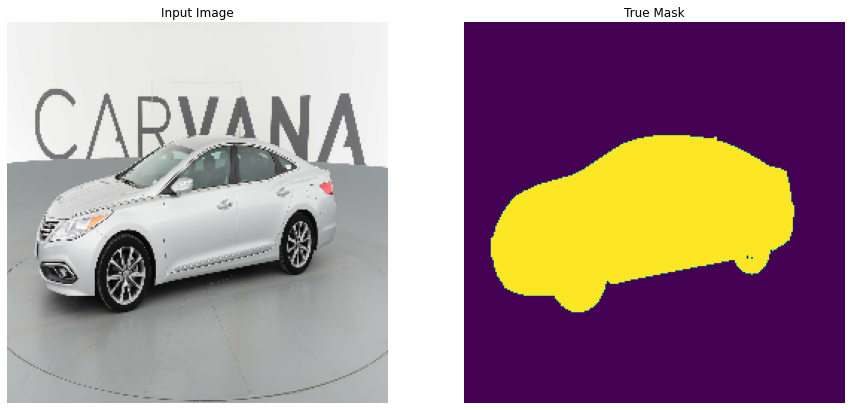

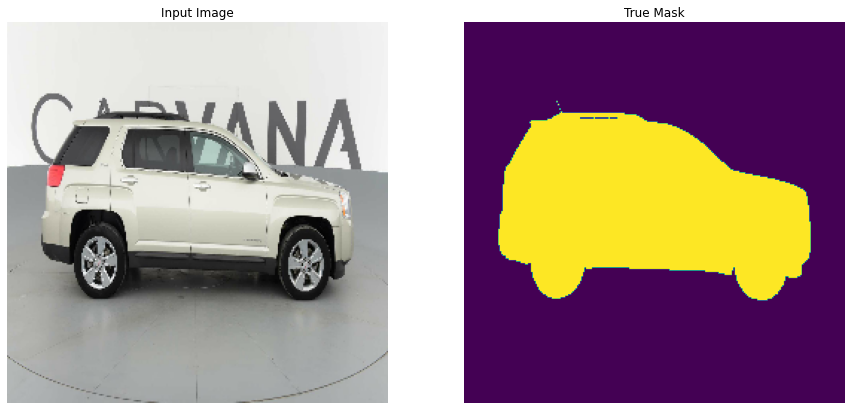

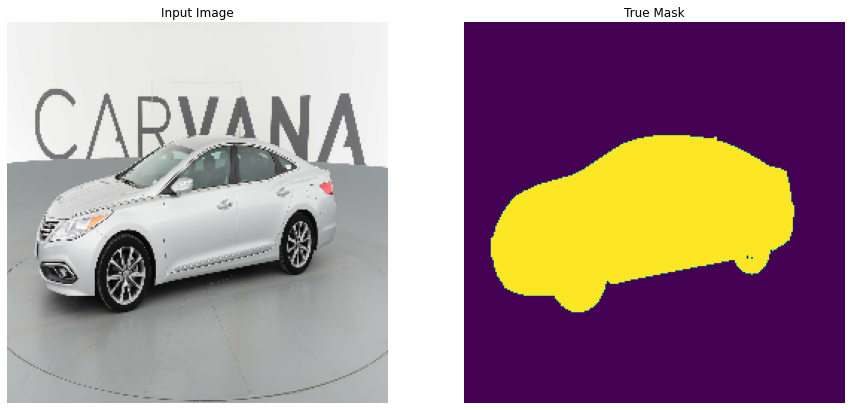

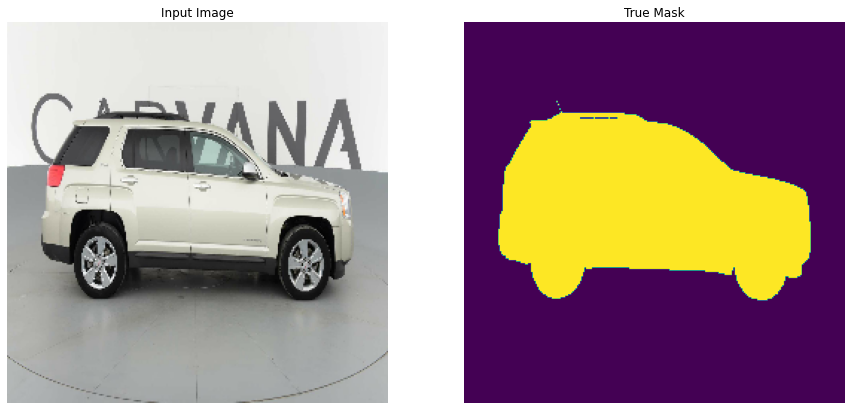

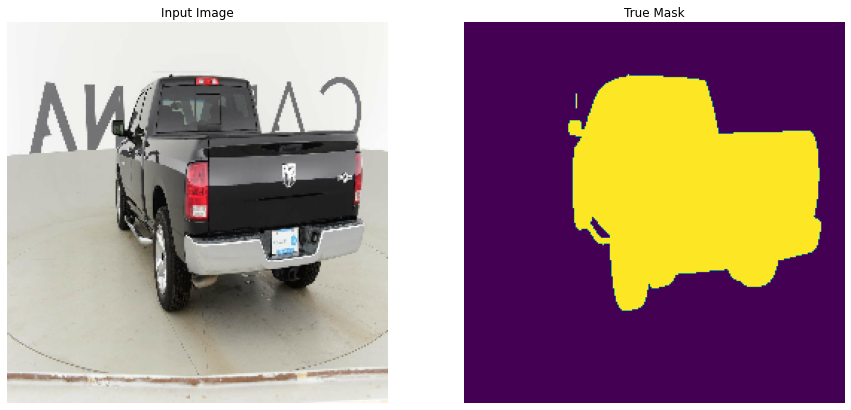

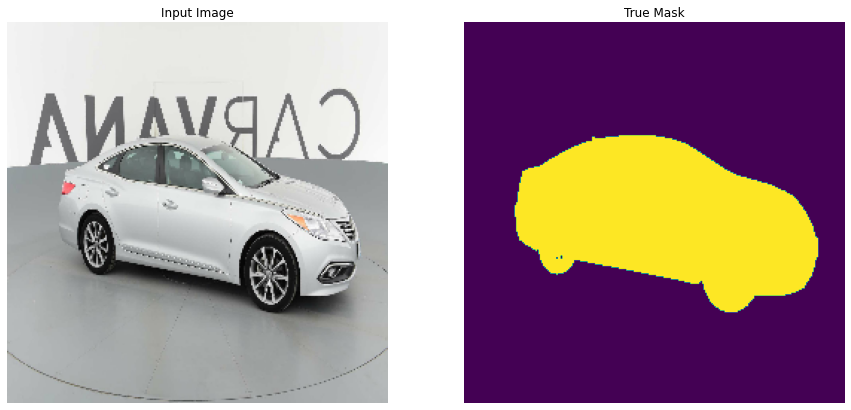

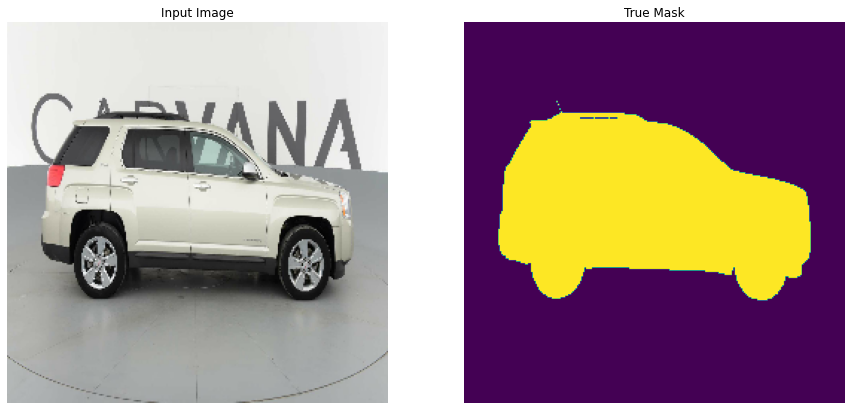

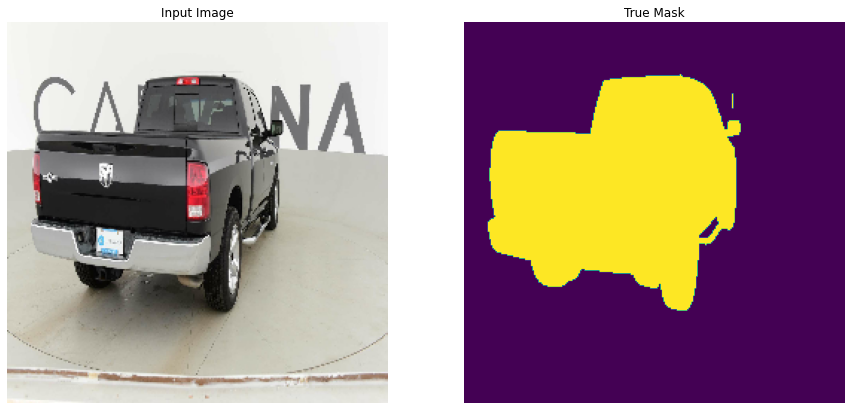

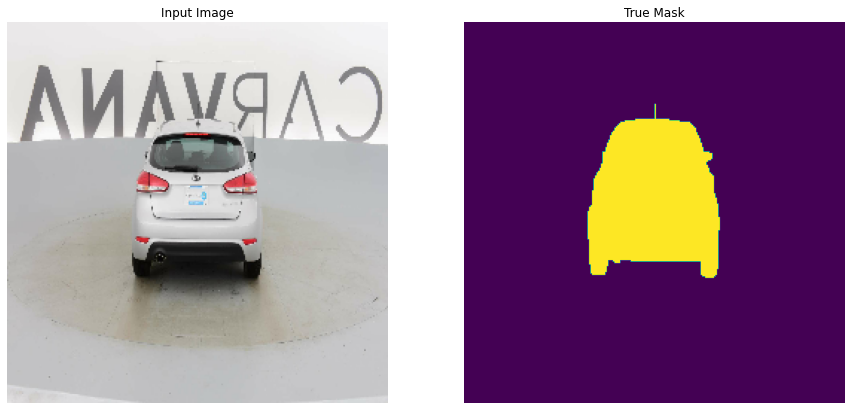

In [ ]:
for i in range(5):
   for image, mask in train.take(i):
        sample_image, sample_mask = image, mask
        display([sample_image, sample_mask])

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

        result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

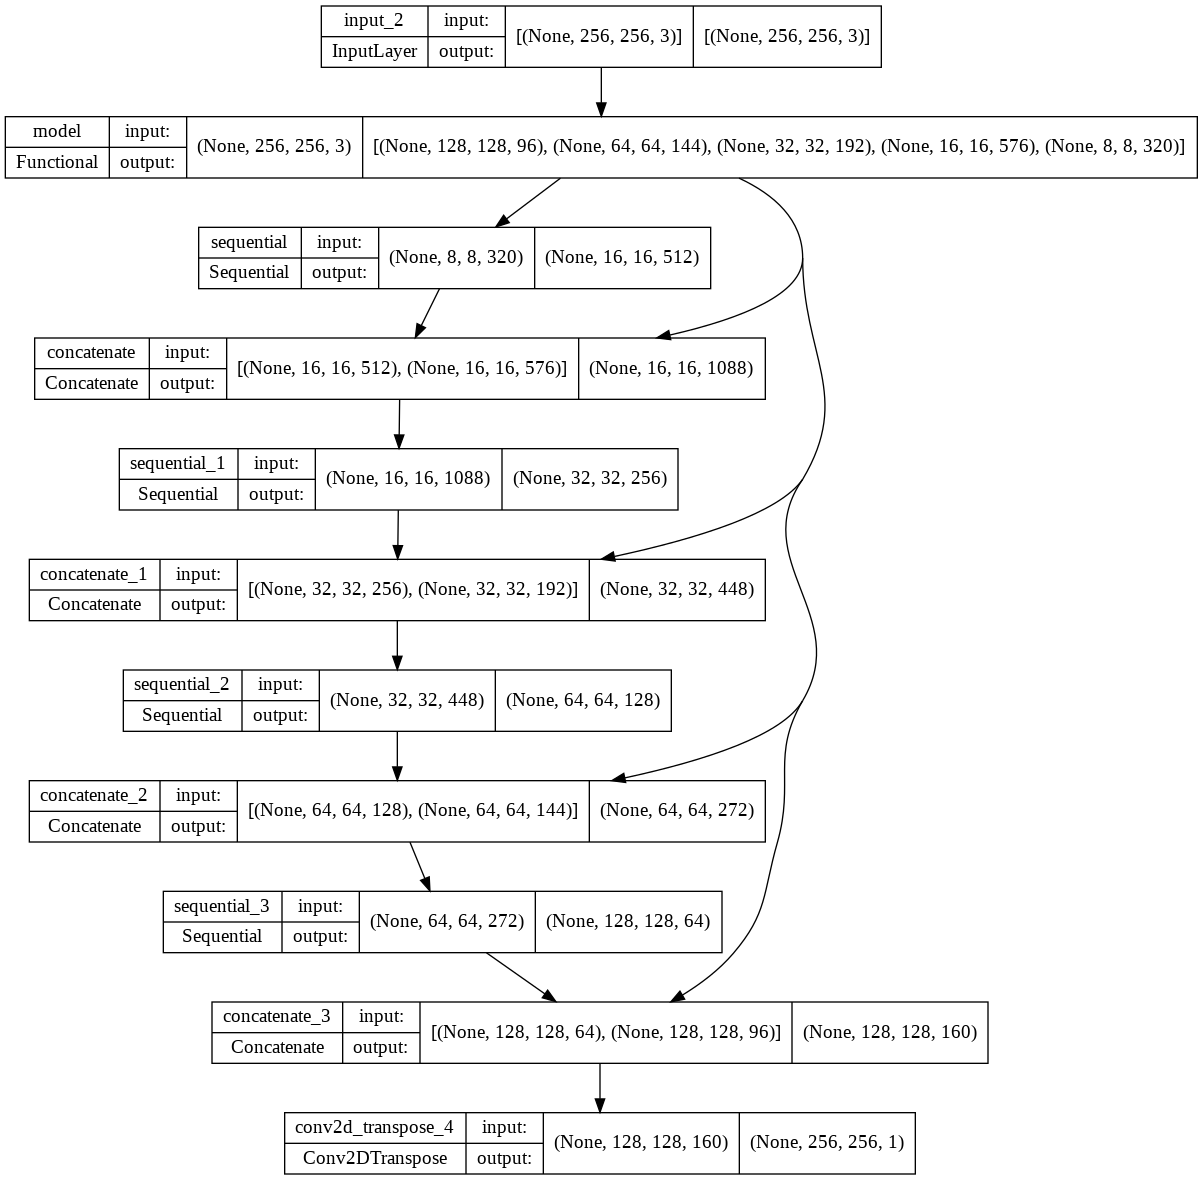

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

model = unet_model(1)

model.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])
    
#show_predictions(sample_image, sample_mask)

NameError: ignored

Epoch 1/15
238/238 [==============================] - 1483s 6s/step - loss: 0.0695 - dice_coef: 0.9305 - binary_accuracy: 0.9742 - val_loss: 0.0310 - val_dice_coef: 0.9690 - val_binary_accuracy: 0.9895
Epoch 2/15
238/238 [==============================] - 1344s 6s/step - loss: 0.0244 - dice_coef: 0.9756 - binary_accuracy: 0.9913 - val_loss: 0.0238 - val_dice_coef: 0.9762 - val_binary_accuracy: 0.9913


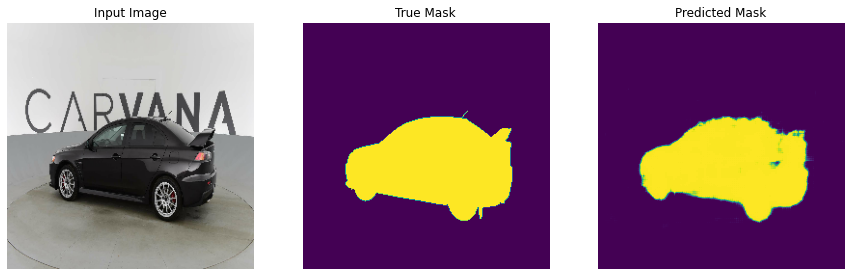

Epoch 3/15
238/238 [==============================] - 1339s 6s/step - loss: 0.0217 - dice_coef: 0.9783 - binary_accuracy: 0.9919 - val_loss: 0.0212 - val_dice_coef: 0.9788 - val_binary_accuracy: 0.9918
Epoch 4/15
238/238 [==============================] - 1365s 6s/step - loss: 0.0202 - dice_coef: 0.9797 - binary_accuracy: 0.9922 - val_loss: 0.0203 - val_dice_coef: 0.9797 - val_binary_accuracy: 0.9920
Epoch 5/15
238/238 [==============================] - 1358s 6s/step - loss: 0.0194 - dice_coef: 0.9806 - binary_accuracy: 0.9924 - val_loss: 0.0198 - val_dice_coef: 0.9802 - val_binary_accuracy: 0.9921


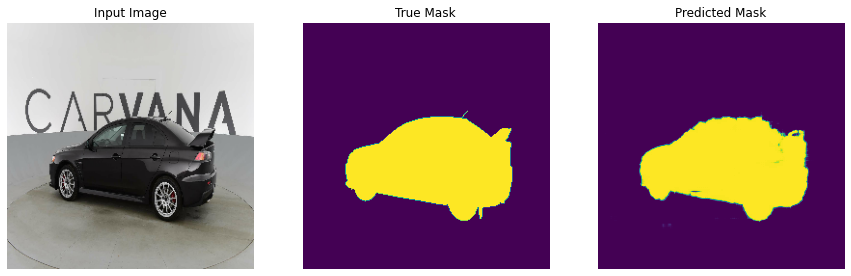

Epoch 6/15
238/238 [==============================] - 1402s 6s/step - loss: 0.0189 - dice_coef: 0.9811 - binary_accuracy: 0.9925 - val_loss: 0.0193 - val_dice_coef: 0.9808 - val_binary_accuracy: 0.9923
Epoch 7/15
238/238 [==============================] - 1407s 6s/step - loss: 0.0184 - dice_coef: 0.9816 - binary_accuracy: 0.9927 - val_loss: 0.0190 - val_dice_coef: 0.9810 - val_binary_accuracy: 0.9923
Epoch 8/15
238/238 [==============================] - 1372s 6s/step - loss: 0.0180 - dice_coef: 0.9820 - binary_accuracy: 0.9928 - val_loss: 0.0188 - val_dice_coef: 0.9812 - val_binary_accuracy: 0.9924


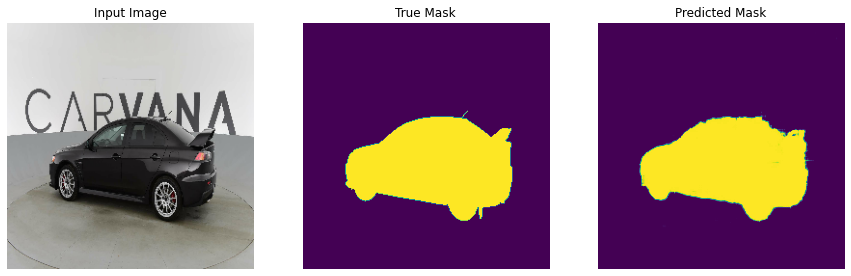

Epoch 9/15
238/238 [==============================] - 1384s 6s/step - loss: 0.0178 - dice_coef: 0.9822 - binary_accuracy: 0.9928 - val_loss: 0.0186 - val_dice_coef: 0.9815 - val_binary_accuracy: 0.9924
Epoch 10/15
238/238 [==============================] - 1369s 6s/step - loss: 0.0174 - dice_coef: 0.9826 - binary_accuracy: 0.9929 - val_loss: 0.0182 - val_dice_coef: 0.9818 - val_binary_accuracy: 0.9925
Epoch 11/15
238/238 [==============================] - 1406s 6s/step - loss: 0.0173 - dice_coef: 0.9827 - binary_accuracy: 0.9929 - val_loss: 0.0183 - val_dice_coef: 0.9817 - val_binary_accuracy: 0.9925


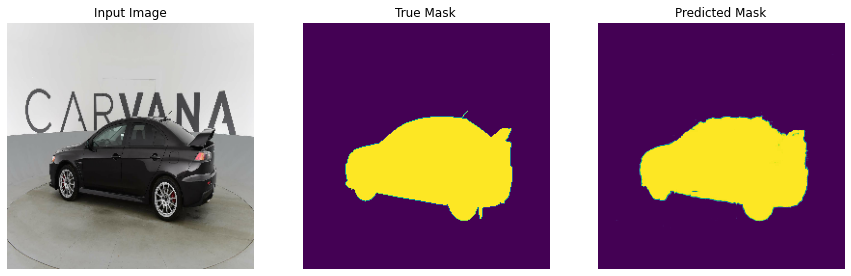

Epoch 12/15
238/238 [==============================] - 1376s 6s/step - loss: 0.0171 - dice_coef: 0.9829 - binary_accuracy: 0.9930 - val_loss: 0.0184 - val_dice_coef: 0.9816 - val_binary_accuracy: 0.9924
Epoch 13/15
238/238 [==============================] - 1295s 5s/step - loss: 0.0168 - dice_coef: 0.9832 - binary_accuracy: 0.9931 - val_loss: 0.0181 - val_dice_coef: 0.9819 - val_binary_accuracy: 0.9925
Epoch 14/15
238/238 [==============================] - 1368s 6s/step - loss: 0.0168 - dice_coef: 0.9832 - binary_accuracy: 0.9931 - val_loss: 0.0192 - val_dice_coef: 0.9808 - val_binary_accuracy: 0.9920


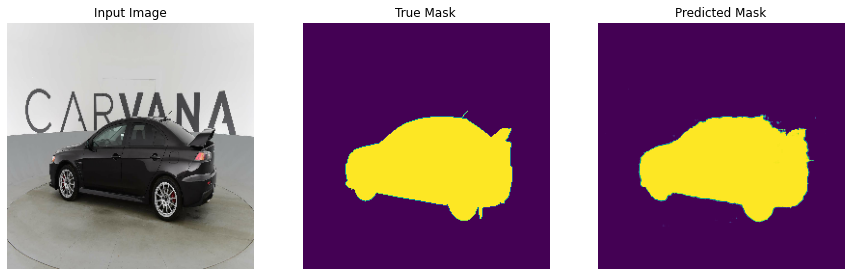

Epoch 15/15
238/238 [==============================] - 1308s 5s/step - loss: 0.0165 - dice_coef: 0.9835 - binary_accuracy: 0.9932 - val_loss: 0.0183 - val_dice_coef: 0.9817 - val_binary_accuracy: 0.9924


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)
EPOCHS = 15
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), early_stop])

In [ ]:
model.save("/content/drive/MyDrive/car_mask_model/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/car_mask_model/assets


In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/car_mask_model/", custom_objects={'dice_loss':dice_loss, 'dice_coef':dice_coef})

In [ ]:
!unzip "/content/mask_img.zip" -d "/content/"

Archive:  /content/mask_img.zip
   creating: /content/mask_img/
  inflating: /content/mask_img/225.jpg  
  inflating: /content/mask_img/312.jpg  
  inflating: /content/mask_img/313.jpg  
  inflating: /content/mask_img/396.jpg  
  inflating: /content/mask_img/422.jpg  
  inflating: /content/mask_img/869.jpg  
  inflating: /content/mask_img/922.jpg  


In [ ]:
import cv2
img_arr = []
for img_name in os.listdir("/content/mask_img/"):
  img_path = os.path.join("/content/mask_img/",img_name)
  img = cv2.imread(img_path)
  img = cv2.resize(img, (256,256))
  img = np.array(img).astype('float')/255.0
  img_arr.append(img)

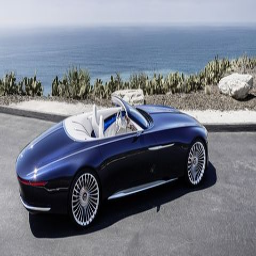

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img_arr[0]*255)

(-0.5, 255.5, 255.5, -0.5)

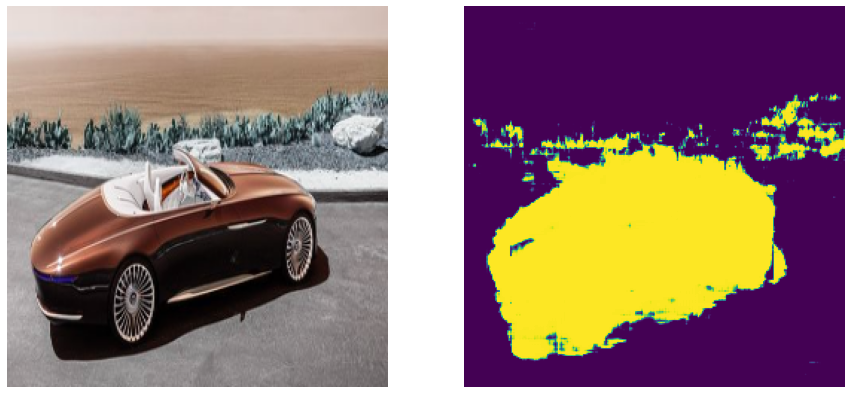

In [ ]:
i = 0
plt.figure(figsize=(15,15))
pred_mask = model.predict(img_arr[i][tf.newaxis, ...])
pred_mask = pred_mask.reshape(img_arr[0].shape[0],img_arr[0].shape[1],1)
plt.subplot(1,2,1)
plt.imshow(tf.keras.preprocessing.image.array_to_img(img_arr[i]))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask))
plt.axis('off')

In [ ]:
mask = pred_mask*255

In [ ]:
def morph_mask(mask,dil_k, ero_k, dil_iter, ero_iter):
  dil_kernel = np.ones((dil_k,dil_k), np.uint8)
  ero_kernel = np.ones((ero_k,ero_k), np.uint8)
  new_mask = cv2.dilate(mask, dil_kernel, iterations = dil_iter)
  #new_mask = cv2.erode(mask, ero_kernel, iterations = ero_iter)
  masked = np.expand_dims(new_mask,-1)*img_arr[i]
  return mask, masked

In [ ]:
mask, masked = morph_mask(mask,2,1,3,1)

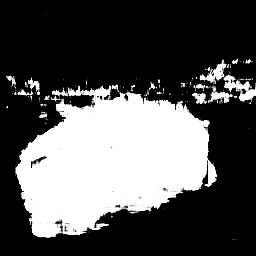

In [ ]:
cv2_imshow(mask)

In [ ]:
__, thresh = cv2.threshold(mask, 150, 255, cv2.THRESH_BINARY)
thresh = cv2.convertScaleAbs(thresh)
height, width = masked.shape[:2]
T = np.float32([[1, 0, 20], [0, 1, -25]])
img_translation = cv2.warpAffine(masked, T, (width, height))
rotated = imutils.rotate(img_translation, -15)

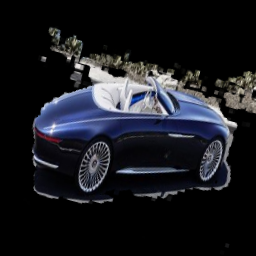

In [ ]:
cv2_imshow(rotated)